In [19]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.Collecting tensorflow



ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\MAXPC\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\Users\MAXPC\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\MAXPC\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\MAXPC\anaconda3\lib\http\client.py", line 458, in read
    n = self.readinto(b)
  File "C:\Users\MAXPC\anaconda3\lib\http\client.py", line 502, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\MAXPC\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\MAXPC\anaconda3\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\MAXPC\anaconda3\lib\ssl.py", line 1099, in read
    return self._sslobj.read(len, buffer)
soc

In [16]:
pip install 

Note: you may need to restart the kernel to use updated packages.


ERROR: You must give at least one requirement to install (see "pip help install")


In [3]:
import os
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/Github/dus_mm/')
import numpy as np
import pandas as pd
import utils
import glob

from matplotlib import pyplot as plt
import seaborn as sb
os.chdir('data')

columnsX = ['freq','AX','BX','BY','CY','CX','DX','DY','AY']
columnsY = ['AX','BX','BY','CY','CX','DX','DY','AY','AQ','AL','BQ','BL','CQ','CL','DQ','DL']
columnsYout = ['AQ','AL','BQ','BL','CQ','CL','DQ','DL','X','Y','Q','L']

In [4]:
X = pd.DataFrame()
y = pd.DataFrame()
numb_files = len(glob.glob('data_output*'))
for i in glob.glob('data_output*'): 
    numb = i[11]
    if (numb == 'data_output.txt'):
        numb = ''
    y = pd.concat([y,pd.read_table(os.path.join('data_output%s.txt' % numb), header = 0, names = columnsY, 
                                   index_col = False, sep='\s+', engine='python', dtype ='float64')], ignore_index = 1)
    X = pd.concat([X,pd.read_table(os.path.join('data_input%s.txt' % numb), header = 0, names = columnsX, 
                                   index_col = False, sep='\s+', engine='python', dtype ='float64')], ignore_index = 1)
#X = X.loc[:1000*4+3]
#y = y.loc[:1000]

X = utils.init_in(X)
y = utils.decomposition(y)

In [11]:
class Layer():
    def __init__(self, neurons: int = 256, activation: str = 'linear'):
        self.neurons = neurons
        self.activation = activation


In [12]:
class NN_model():
  
    def __init__(self, input_dimension: int, loss = 'mean_squared_error'):
        self.sequential = [Layer(input_dimension)]
        self.theta = np.array([])
        self.loss = loss
        self.optimizer = 'gradient_descent' #'adam'
        self.max_epoch = 100
        self.chunk_size = 1000
        self.beta_1 = 0.9
        self.beta_2 = 0.99
        self.epsilon = 1e-8
        self.learning_rate = 0.1
        self.regularization = None #'l2'

    def add(self, layer: Layer):
        self.sequential.append(layer)
        layer_in = self.sequential[-2]
        layer_out = self.sequential[-1]
        gamma = np.sqrt(6)/np.sqrt(layer_in.neurons + layer_out.neurons)
        np.random.seed(0)
        init_theta = np.random.rand(layer_out.neurons,layer_in.neurons + 1) * 2 * gamma - gamma
        self.theta = np.hstack([self.theta, init_theta.ravel()])


    def activation(self, layer: Layer, x, diff: bool = False):
        if (layer.activation == 'relu'):
            if (diff == True):
                x[x >= 0] = 1
                x[x < 0] = 0
            else:
                x[x < 0] = 0
        elif (layer.activation == 'linear'):
            if (diff == True):
                x = 1
            else:
                x = x
        elif (layer.activation == 'sigmoid'):
            if (diff == True):
                x = self.activation(layer, x) * (1 - self.activation(layer, x))
            else:
                x = 1/(1 + np.exp(-x))
        return x

    def feedforward(self, x, theta_new = None):
        if (theta_new is None):
            theta_new = self.theta
        a = x
        a_out = np.array(a.ravel())
        slice_theta1 = 0
        for i in range(1, len(self.sequential)):
            layer1 = self.sequential[i - 1]
            layer2 = self.sequential[i]
            slice_theta2 = slice_theta1 + (layer1.neurons + 1) * layer2.neurons
            
            theta1 = theta_new[slice_theta1:slice_theta2].reshape(layer2.neurons, layer1.neurons + 1)
            z = np.dot(np.concatenate((np.ones([a.shape[0],1]), a), axis = 1), theta1.T)
            a = self.activation(layer2, z)
            a_out = np.hstack([a.ravel(), a_out])
            slice_theta1 = slice_theta2
        return a_out

    def backprop(self, a_out, y, theta_new = None):
        if (theta_new is None):
            theta_new = self.theta
        grad = np.array([])
        slice_theta1 = 0
        slice_a1 = 0
        for i in range(1, len(self.sequential)):
            layer1 = self.sequential[-i]
            layer2 = self.sequential[-(i + 1)]
            slice_theta2 = slice_theta1 + layer1.neurons * (layer2.neurons + 1)
            slice_a2 = slice_a1 + layer1.neurons * y.shape[0]
            slice_a3 = slice_a2 + layer2.neurons * y.shape[0]           
            a1 = a_out[slice_a1:slice_a2].reshape((y.shape[0], layer1.neurons))
            a2 = a_out[slice_a2:slice_a3].reshape((y.shape[0], layer2.neurons))
            a2 = np.concatenate((np.ones([a2.shape[0], 1]), a2), axis = 1)
            theta2 = np.flip(theta_new)[slice_theta1:slice_theta2].reshape(layer1.neurons, layer2.neurons + 1)
            theta2 = np.flip(theta2)
            if (i == 1):
                delta = self.compute_loss(a_out, y, diff = True) * self.activation(layer1, np.dot(a2, theta2.T), diff = True)
            else:
                delta = np.dot(delta, theta1[:,1:]) * self.activation(layer1, np.dot(a2, theta2.T), diff = True)  
            grad = np.hstack([np.dot(delta.T, a2).ravel(), grad])
            
            theta1 = theta2  
            slice_theta1 = slice_theta2
            slice_a1 = slice_a2
        grad = (1 / y.shape[0]) * grad
        return grad

    def nulling(self, theta_new2 = None):
        if (theta_new2 is None):
            theta_new2 = self.theta.copy()
        slice_theta1 = 0
        for i in range(1, len(self.sequential)):
            layer1 = self.sequential[i - 1]
            layer2 = self.sequential[i]
            slice_theta2 = slice_theta1 + (layer1.neurons + 1) * layer2.neurons
            theta_new2[slice_theta1:slice_theta2:layer1.neurons] = 0
            slice_theta1 = slice_theta2
        return theta_new2
          

    def compute_loss(self, a_out, y, theta_new = None,  diff: bool = False):
        if (theta_new is None):
            theta_new = self.theta.copy()
        a_end = a_out[:(self.sequential[-1].neurons * y.shape[0])]
        a_end = a_end.reshape((y.shape[0], self.sequential[-1].neurons))
        if (self.loss == 'mean_squared_error'):
            if (diff == True):
                loss = (a_end - y)
            else:
                loss = np.sum(np.power((a_end - y), 2)) / (2 * y.shape[0])
        elif (self.loss == 'loglos'):
            if (diff == True):
                loss = (a_end - y)/((1 - a_end) * a_end)
            else:
                loss = - np.sum(y * np.log(a_end) + (1 - y) * np.log(1 - a_end))/y.shape[0]     
        return loss
    
    def form_output(self, X, y):
        a_out = self.feedforward(X_train)
        a_end = a_out[:(self.sequential[-1].neurons * y.shape[0])]
        return a_end

    def gradient_checking(self, x, y, e = 1e-4):
        numgrad = np.zeros(self.theta.shape)
        perturb = np.diag(e * np.ones(self.theta.shape))
        for i in range(self.theta.size):
            theta_plus = self.theta + perturb[:,i]
            theta_minus = self.theta - perturb[:,i]
            a_out_plus  = self.feedforward(x, theta_plus)
            a_out_minus = self.feedforward(x, theta_minus)
            numgrad[i] = (self.compute_loss(a_out_plus, y, theta_plus) - self.compute_loss(a_out_minus, y, theta_minus))/(2 * e)
        a_out = self.feedforward(x)
        grad = self.backprop(a_out, y)
        diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)
        print('Relative Difference: %g' % diff)


    def optimize(self, X_train, y_train, X_val, y_val, lambda_new = 0):
        for epoch in range(self.max_epoch):
            m = np.zeros(self.theta.shape)
            v = np.zeros(self.theta.shape)
            lst =  np.arange(y_train.shape[0])
            np.random.shuffle(lst)
            chunks = np.array([lst[i: i + self.chunk_size] for i in range(0, y_train.shape[0], self.chunk_size)])
            theta_new = self.theta.copy()
            for t, chunk in enumerate(chunks):
                xi = X_train[chunk]
                yi = y_train[chunk]
                a_out = self.feedforward(xi, theta_new)
                grad = self.backprop(a_out, yi, theta_new)  
                if (self.optimizer == 'adam'):
                    #Ti = 0.1 *
                    #self.lambda_ = 0.025 * np.sqrt(self.chunk_size/(y.shape[0]*
                    grad = grad + (lambda_new) * self.nulling(theta_new)
                    m = self.beta_1 * m + (1 - self.beta_1) * grad
                    v = self.beta_2 * v + (1 - self.beta_2) * np.power(grad, 2)
                    m_hat = m / (1 - np.power(self.beta_1, t + 1))
                    v_hat = v / (1 - np.power(self.beta_2, t + 1))
                    theta_new = theta_new - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon) - (lambda_new) * self.nulling(theta_new)
                elif (self.optimizer == 'gradient_descent'):
                    theta_new = theta_new - self.learning_rate * grad -  lambda_new * self.nulling(theta_new)
            a_out_train = self.feedforward(X_train, theta_new)
  
            loss_train = self.compute_loss(a_out_train, y_train, theta_new)# + lambda_new * np.sum(np.power(self.nulling(theta_new), 2))/2
            a_out_val = self.feedforward(X_val, theta_new)
            loss_val = self.compute_loss(a_out_val, y_val, theta_new) #+ lambda_new * np.sum(np.power(self.nulling(theta_new), 2))/2

            self.theta = theta_new
            print(f'{np.round(loss_train,2)}    {np.round(loss_val,2)}    {epoch}')
        return loss_train, loss_val
    
    def __repr__(self):
        return str(len(self.sequential))

In [14]:
dus_mm = NN_model(X.shape[1], 'loglos')
dus_mm.add(Layer(128, 'sigmoid'))
dus_mm.add(Layer(128, 'sigmoid'))
dus_mm.add(Layer(y.shape[1], 'sigmoid'))

In [300]:
import scipy.io
mat = scipy.io.loadmat('mnist.mat')
X = mat['X']
y = mat['y']
y[y == 10] = 0
y0 = np.zeros((y.size, 10))
for i in range(y.shape[0]):
    y0[i,y[i]] = 1
y = y0

In [187]:
# dus_mm = NN_model(X.shape[1])
# dus_mm.add(Layer(128, 'relu'))
# dus_mm.add(Layer(128, 'relu'))
# dus_mm.add(Layer(128, 'relu'))
# dus_mm.add(Layer(y.shape[1], 'relu'))

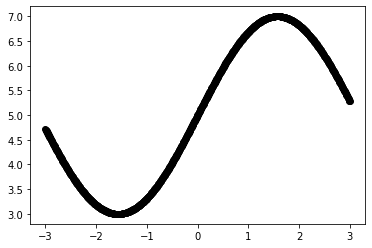

In [364]:
import matplotlib.pyplot as plt
import numpy as np

# накидываем тысячу точек от -3 до 3
X = np.linspace(-3, 3, 1000).reshape(-1, 1)

# задаём линейную функцию, которую попробуем приблизить нашей нейронной сетью
def f(x):    
    return 2 * np.sin(x) + 5

f = np.vectorize(f)

# вычисляем вектор значений функции
y = f(X)

# отрисовываем результат приближения нейросетью поверх исходной функции
plt.scatter(X_train, y, color='black', antialiased=True)
#plt.plot(, model.predict(x), color='magenta', linewidth=2, antialiased=True)
plt.show()

# выводим веса на экран
# for layer in model.layers:
#     weights = layer.get_weights()
#     print(weights)

In [389]:
dus_mm = NN_model(X.shape[1], 'mean_squared_error')
dus_mm.add(Layer(y.shape[1], 'linear'))

In [390]:
X = np.array(X)
y = np.array(y)
lambda_vec = [0]

nfold = 5
slice_fold = int(y.shape[0] // nfold)
lst =  np.arange(y.shape[:(5 * slice_fold)][0])
np.random.shuffle(lst)
list_fold = np.array([lst[i * slice_fold:(i + 1) * slice_fold] for i in range(nfold)])

train_error = np.zeros(nfold)
val_error = np.zeros(nfold)
train_reg = np.zeros(len(lambda_vec))
val_reg = np.zeros(len(lambda_vec))

for k in range(len(lambda_vec)):
    for i in range(nfold):
        X_train = X[np.delete(list_fold, i, 0).ravel()]
        y_train = y[np.delete(list_fold, i, 0).ravel()]
        X_val = X[list_fold[i]]
        y_val = y[list_fold[i]]
        train_error[i], val_error[i] = dus_mm.optimize(X_train, y_train, X_val, y_val, lambda_vec[k])
    train_reg[k] = np.mean(train_error)  
    val_reg[k] = np.mean(val_error)

9.81    9.68    0
8.0    7.91    1
6.54    6.47    2
5.36    5.31    3
4.4    4.36    4
3.63    3.59    5
3.0    2.97    6
2.49    2.47    7
2.08    2.06    8
1.75    1.73    9
1.48    1.47    10
1.26    1.25    11
1.08    1.08    12
0.94    0.93    13
0.82    0.82    14
0.73    0.73    15
0.65    0.65    16
0.59    0.59    17
0.54    0.54    18
0.5    0.5    19
0.47    0.47    20
0.44    0.45    21
0.42    0.43    22
0.4    0.41    23
0.39    0.4    24
0.38    0.39    25
0.37    0.38    26
0.36    0.37    27
0.35    0.37    28
0.35    0.36    29
0.34    0.36    30
0.34    0.35    31
0.34    0.35    32
0.34    0.35    33
0.33    0.35    34
0.33    0.35    35
0.33    0.35    36
0.33    0.35    37
0.33    0.35    38
0.33    0.35    39
0.33    0.35    40
0.33    0.35    41
0.33    0.34    42
0.33    0.34    43
0.33    0.34    44
0.33    0.34    45
0.33    0.34    46
0.33    0.34    47
0.33    0.34    48
0.33    0.34    49
0.33    0.34    50
0.33    0.34    51
0.33    0.34    52
0.33    0.

In [ ]:
a_out_train = self.feedforward(X_train)

In [384]:
dus_mm.form_output(X_val)

array([6.6190037 , 5.42486947, 4.16073427, 4.39956112, 5.28486753,
       6.36782374, 3.04483642, 3.88484808, 4.1936759 , 5.84899301,
       5.08310002, 6.60253289, 7.0019502 , 3.91778972, 6.48723717,
       3.16013214, 5.5484006 , 3.65425665, 2.99130626, 3.25072163,
       3.06130724, 4.92250955, 4.21014672, 4.21426442, 6.76724106,
       6.18664476, 3.1189551 , 3.35778194, 5.9354648 , 2.93777611,
       6.11252608, 5.86546383, 6.05487822, 4.79074302, 4.81544924,
       5.97252414, 6.2237041 , 4.44485586, 6.73018172, 4.03308544,
       3.88073038, 3.72425762, 5.11604165, 5.81605138, 3.96720217,
       5.77075663, 6.31429359, 3.5142547 , 4.23485295, 4.91839185,
       4.29661851, 4.14838116, 4.01249692, 4.72074205, 6.49135487,
       4.46544438, 4.05367396, 4.04543855, 5.00486364, 4.24720606,
       5.22721967, 6.99371479, 3.51837241, 3.76543466, 6.21135098,
       3.74072844, 4.02073232, 5.12839477, 3.97131987, 5.31369146,
       4.56015158, 4.16485197, 6.59429748, 3.95073135, 4.53544

In [382]:
X_val.shape

(200, 1)

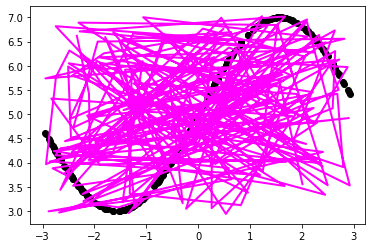

In [391]:
# отрисовываем результат приближения нейросетью поверх исходной функции
plt.scatter(X_val, y_val, color='black', antialiased=True)
plt.plot(X_val, dus_mm.form_output(X_val,y_val), color='magenta', linewidth=2, antialiased=True)
plt.show()

In [368]:
f = dus_mm.gradient_checking(X,y)

Relative Difference: 1.47801e-11


In [220]:
lambda_vec = [0]
error_train = np.zeros(len(lambda_vec))
error_val = np.zeros(len(lambda_vec))
init_theta = dus_mm.theta

for i in range(len(lambda_vec)):
  dus_mm.theta = init_theta.copy()
  dus_mm.optimize(X_train, y_train, lambda_vec[i]) 
  a_out = dus_mm.feedforward(X_train)
  a_end = a_out[:(dus_mm.sequential[-1].neurons * y_train.shape[0])]
  error_train[i] = dus_mm.compute_loss(a_end, y_train)
  
  a_out = dus_mm.feedforward(X_val)
  a_end = a_out[:(dus_mm.sequential[-1].neurons * y_val.shape[0])]
  error_val[i] = dus_mm.compute_loss(a_end, y_val)

TypeError: ignored

lambda		Train Error	Validation Error
 0.000000	49.380953	58.266060


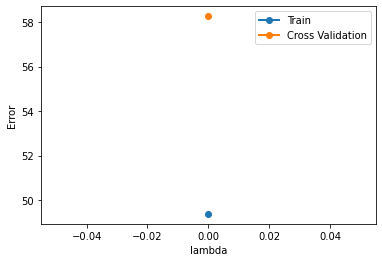

In [ ]:
plt.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('lambda')
plt.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

In [ ]:
a_out = dus_mm.feedforward(X_val)
a_end = a_out[:(dus_mm.sequential[-1].neurons * y_val.shape[0])]
loss = dus_mm.compute_loss(a_end, y_val.ravel())

In [ ]:
loss

9.15514514900138

In [ ]:
y[300:301]

array([[ 0.,  4.,  0.,  2.,  0.,  0., 14.,  0.,  0., 12.,  8.,  0.]])

In [ ]:
np.round(dus_mm.feedforward(np.array(X[300:301]))[:12])

array([ 0.,  4.,  0.,  1.,  2.,  0., 14.,  0.,  0., 12.,  8.,  0.])

In [ ]:
import scipy.io
mat = scipy.io.loadmat('mnist.mat')
X = mat['X']
y = mat['y']
y[y == 10] = 0
y0 = np.zeros((y.size, 10))
for i in range(y.shape[0]):
    y0[i,y[i]] = 1

In [ ]:
dus_mm = NN_model(X.shape[1], 'loglos')
dus_mm.add(Layer(128, 'sigmoid'))
dus_mm.add(Layer(128, 'sigmoid'))
dus_mm.add(Layer(y0.shape[1], 'sigmoid'))

In [ ]:
X = np.array(X)
y = np.array(y)
lst =  np.arange(y.shape[0])
np.random.shuffle(lst)
split_data = int(0.8 * y.shape[0])

X_train = X[lst[:split_data]]
y_train = y[lst[:split_data]]
X_val = X[lst[split_data:y.shape[0]]]
y_val = y[lst[split_data:y.shape[0]]]

In [ ]:
dus_mm.optimize(X_train, y_train, X_val, y_val )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in multiply


nan    nan


KeyboardInterrupt: ignored

In [ ]:
dus_mm.feedforward(X[600:601,:])[:10]

array([0.86022436, 0.90403858, 0.90021411, 0.90532145, 0.90544177,
       0.9029935 , 0.90745175, 0.90001685, 0.86896561, 0.90270247])

In [ ]:
y0[600]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
 a = [1,2,3]

In [ ]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])